# Sales Assistant

Additional concepts:

- Thread management for multiple users
  - Using shelves to store the user threads
  - Thread will be created or reused as different users access the assistant
- Relationships in files

### Load the required libraries

In [1]:
import html
import io
import os
import time
import shelve
from datetime import datetime
from pathlib import Path
from typing import Iterable

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta import Thread
from openai.types.beta.threads import Run
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile
from PIL import Image

# List of assistants created
ai_assistants = []
# List of threads created
ai_threads = []
# List of files uploaded
ai_files = []

### Load the environment variables

In [2]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

### Handle state

In [3]:
def add_thread(thread):
    for item in ai_threads:
        if item.id == thread.id:
            return
    ai_threads.append(thread)
    print("Added thread: ", thread.id, len(ai_threads))

def check_if_thread_exists(user_id):
    with shelve.open("threads_db") as threads_shelf:
        return threads_shelf.get(user_id, None)

def store_thread(user_id, thread):
    with shelve.open("threads_db", writeback=True) as threads_shelf:
        add_thread(thread)
        threads_shelf[user_id] = thread.id

def clear_shelves():
    with shelve.open("assistant_db") as assistant_shelf:
        assistant_shelf.clear()
    with shelve.open("threads_db") as threads_shelf:
        threads_shelf.clear()

clear_shelves()

### Create an AzureOpenAI client

In [4]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

### Define the Assistant tools

In [5]:
tools_list = [
    {"type": "code_interpreter"}
]

### Upload the file(s)

In [6]:
DATA_FOLDER = "data/sales/"

def upload_file(client: AzureOpenAI, path: str) -> FileObject:
    print(path)
    with Path(path).open("rb") as f:
        return client.files.create(file=f, purpose="assistants")

arr = os.listdir(DATA_FOLDER)
assistant_files = []
for file in arr:
    filePath = DATA_FOLDER + file
    assistant_file = upload_file(client, filePath)
    ai_files.append(assistant_file)
    assistant_files.append(assistant_file)

file_ids = [file.id for file in assistant_files]

data/sales/sellers.csv
data/sales/customers.csv
data/sales/orders.csv
data/sales/inventory.csv


### Create an Assistant and a Thread

In [7]:
assistant = client.beta.assistants.create(
    name="Sales Assistant",
    instructions="You are a sales assistant. You can answer questions related to customer orders.",
    tools=tools_list,
    model=api_deployment_name,
    file_ids=file_ids,
)
ai_assistants.append(assistant)

### Process Function calling

In [8]:
def read_assistant_file(file_id:str):
    response_content = client.files.content(file_id)
    return response_content.read()

def print_messages(name: str, messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                if message.role == "user":
                    print(f"user: {name}:\n{item.text.value}\n")
                else:
                    print(f"{message.role}:\n{item.text.value}\n")
                file_annotations = item.text.annotations
                if file_annotations:
                    for annotation in file_annotations:
                        file_id = annotation.file_path.file_id
                        content = read_assistant_file(file_id)
                        print(f"Annotation Content:\n{str(content)}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id                
                data_in_bytes = read_assistant_file(item.image_file.file_id)
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image
                image.show()

### Process the user messages

In [9]:
def process_prompt(name, user_id, prompt: str) -> None:

    thread_id = check_if_thread_exists(user_id)

     # If a thread doesn't exist, create one and store it
    if thread_id is None:
        print(f"Creating new thread for {name} with user_id {user_id}")
        thread = client.beta.threads.create()
        store_thread(user_id, thread)
        thread_id = thread.id
    # Otherwise, retrieve the existing thread
    else:
        print(f"Retrieving existing thread for {name} with user_id {user_id}")
        thread = client.beta.threads.retrieve(thread_id)
        add_thread(thread)

    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=prompt)
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="Please address the user as Jane Doe. The user has a premium account. Be assertive, accurate, and polite. Ask if the user has further questions. Do not provide explanations for the answers."
        + "The current date and time is: "
        + datetime.now().strftime("%x %X")
        + ". ",
    )

    print("processing ...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            # Handle completed
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            print_messages(name, messages)
            break
        if run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            print_messages(name, messages)
            # Handle failed
            break
        if run.status == "expired":
            # Handle expired
            print(run)
            break
        if run.status == "cancelled":
            # Handle cancelled
            print(run)
            break
        if run.status == "requires_action":            
            pass
        else:
            time.sleep(5)

### Have a conversation with the Assistant

In [10]:
process_prompt("John", "user_123", "What customers are in Florida?")

Creating new thread for John with user_id user_123
Added thread:  thread_qA7gTRMCVaIK6HBpFSZqY3OI 1
processing ...
user: John:
What customers are in Florida?

assistant:
To find out which customers are in Florida, I need to examine the contents of the files you've uploaded. I will start by identifying the file types and examining their contents to search for customer data that includes location information pertaining to Florida.

Let's begin by checking the files one at a time. I will first list the files to confirm their names and then proceed to analyze their content.

assistant:
I will now check the content of each file to determine the data format and locate any customer information related to Florida. I will start by inspecting the first file.

assistant:
It seems that the content of the last file (`assistant-ivnqmPvwEdJxGZmxW5BrmiyW`) contains customer information including their State. I will now process this file to identify the customers located in Florida (FL).

assistant:
Th

In [11]:
process_prompt("Mary", "user_234", "What seller has had the most sales?")

Creating new thread for Mary with user_id user_234
Added thread:  thread_AaeRD10109N7xoebWhrJHXkl 2
processing ...
user: Mary:
What seller has had the most sales?

assistant:
To determine which seller has had the most sales, I need to examine the contents of the files you have uploaded. They may contain sales data which can be analyzed to determine the top seller.

I will begin by inspecting the contents of each file to understand the data structure and then analyze that data to answer your question. Let's start with the first file you uploaded.

assistant:
The first file seems to contain information about sellers, including a SellerID, Name, and State. To provide a thorough answer, I will check the contents of all the files you uploaded to gather all the relevant data and then analyze this data to find out which seller has had the most sales. I will continue with the next file.

assistant:
The second file contains information about customers, including a CustomerID, Name, and State. L

In [12]:
process_prompt("John", "user_123", "What is the most sold product?")

Retrieving existing thread for John with user_id user_123
processing ...
user: John:
What is the most sold product?

assistant:
To determine the most sold product, I will need to analyze the order data to find which product has the highest quantity sold. This probably requires combining order details with product information. I will start by examining the content of the file that appears to contain orders or sales data. Let's examine the relevant files to identify the most sold product.

assistant:
The most sold product has the ItemID: 1001, with a total quantity sold of 20 units.

I will now match this ItemID with the product description from the product file to provide you with the product's description. Let's proceed.

assistant:
The most sold product is the "AMD Ryzen 7 Desktop".

Would you like assistance with anything else, Jane Doe?



Retrieving existing thread for Mary with user_id user_234
processing ...
user: Mary:
Chart product sales by State.

assistant:
To chart product sales by state, I will need to merge the sales data with the customer data to obtain the state information for each sale. After merging the data, I will then create a chart showing the product sales by state. Let's proceed with this analysis.



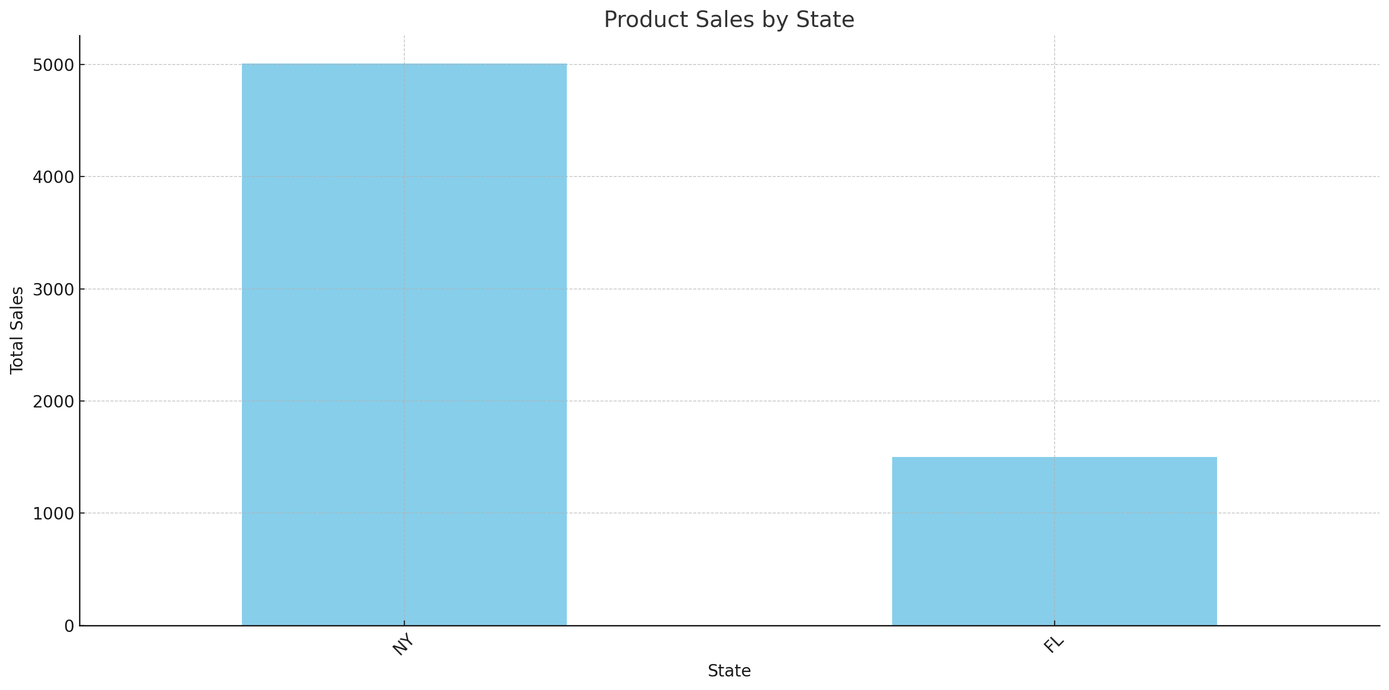

assistant:
The chart displaying product sales by state has been created. If you need further assistance or have any more questions, please feel free to ask.



In [13]:
process_prompt("Mary", "user_234", "Chart product sales by State.")

### Cleanup

In [14]:
def cleanup(client):
    print("Deleting: ", len(ai_assistants), " assistants.")
    for assistant in ai_assistants:
        print(client.beta.assistants.delete(assistant.id))
    print("Deleting: ", len(ai_threads), " threads.")
    for thread in ai_threads:
        print(client.beta.threads.delete(thread.id))
    print("Deleting: ", len(ai_files), " files.")
    for file in ai_files:
        print(client.files.delete(file.id))
        
cleanup(client)

Deleting:  1  assistants.
AssistantDeleted(id='asst_4xZRqjFYgkOrqLs5XVGm5Ybl', deleted=True, object='assistant.deleted')
Deleting:  2  threads.
ThreadDeleted(id='thread_qA7gTRMCVaIK6HBpFSZqY3OI', deleted=True, object='thread.deleted')
ThreadDeleted(id='thread_AaeRD10109N7xoebWhrJHXkl', deleted=True, object='thread.deleted')
Deleting:  4  files.
FileDeleted(id='assistant-Dm9Tt4TT1mZHMXvVgdiE9q1t', deleted=True, object='file')
FileDeleted(id='assistant-ivnqmPvwEdJxGZmxW5BrmiyW', deleted=True, object='file')
FileDeleted(id='assistant-owhhrbnmfYeMwfefMqAKojY3', deleted=True, object='file')
FileDeleted(id='assistant-ppDrfivCGVxSyvUTUbvmrz87', deleted=True, object='file')
